Testing filtering of stop words in dataset. To do this we can use the python natural language toolkit: https://www.nltk.org/

In [8]:
import nltk
from nltk.corpus import stopwords
import string
import unicodedata
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jikael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jikael/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/jikael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')

In [10]:
df['publishedAt'].min(), df['publishedAt'].max()

('2024-10-14T02:54:49Z', '2024-11-04T23:32:32Z')

In [11]:
print(df['topic pass 2'].value_counts(normalize=True).to_latex())

\begin{tabular}{lr}
\toprule
 & proportion \\
topic pass 2 &  \\
\midrule
Elections and Political Strategies & 0.213439 \\
Scandals and Controversies & 0.156126 \\
Political Attack and Accusations & 0.154150 \\
Media and Public Engagement & 0.130435 \\
Foreign Policy and National Security & 0.112648 \\
Domestic Policy & 0.100791 \\
Social Issues & 0.090909 \\
Economic and Financial Issues & 0.041502 \\
\bottomrule
\end{tabular}



In [12]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data/vance.tsv', sep='\t')
df['valid'] = df['description'].map(lambda x: type(x) == str)
df=df[df['valid']]
df['topic'] = np.random.randint(0,9, size=len(df))

In [13]:
len(df)

508

In [14]:
df.iloc()[1]['description']

"Sen. JD Vance, who says running as Trump's VP pick has cost him friends, is wrapping up his by asking voters to not let political differences come between them."

In [15]:
from nltk.tokenize import TweetTokenizer # use this one because the other one struggles with words like "don't"

def filter_sentence(sentence, stop_words, tokenizer):
    word_tokens = tokenizer.tokenize(sentence)
    word_tokens = filter(lambda x: len(x) > 1 and x != '...', word_tokens) # removes all punctuation/symbols found by tokenizer
    filtered_sentence = ' '.join([w for w in word_tokens if (not w.lower() in stop_words)]) # remove stop words
    return filtered_sentence

In [16]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [17]:
word_tokenize("don't eat that!")

['do', "n't", 'eat', 'that', '!']

In [18]:
TweetTokenizer().tokenize("don't eat that!")

["don't", 'eat', 'that', '!']

In [19]:
def pre_process_descriptions(df):
    stop_words = set(stopwords.words('english'))
    tokenizer = TweetTokenizer()
    df['description_processed'] = df['description'].map(lambda x: filter_sentence(x, stop_words, tokenizer))

In [20]:
pre_process_descriptions(df)

In [21]:
def get_corpus_by_category(df):
  corpus_dict = dict()
  for topic in df.topic.unique():
    filtered_df = df[df.topic == topic]
    sentence = ' '.join(filtered_df['description_processed'])
    corpus_dict[topic] = sentence
  return corpus_dict

In [22]:
corpus = get_corpus_by_category(df)

In [23]:
corpus

{0: "Republican vice presidential candidate JD Vance rallied supporters Atlanta taking aim Vice President Kamala Harris criticized Harris response President Joe Biden recent remarks Republican vice-presidential candidate JD Vance told Joe Rogan surprised Trump wins normal gay guy vote podcast interview controversial comedian JD Vance made number claims including people Donald Trump former communications director turned antagonist Anthony Scaramucci says former boss meaner version 2016 version defence supporting interview Sunday Times newspaper references Fix Money Politics Million Already Watched Vance-Rogan Interview Podcaster Joe Rogan Oct 31 released roughly three-and-a-half-hour interview Sen JD Vance R-Ohio former President Donald Trump running mate Evenin friendly confines joe Rogan podcast JD Vance can't help flustered unprepared damn weird US vice-presidential candidate JD Vance made comment childless cat ladies evoked image educated urbanite career-minded women picture childle

Now we can perform tf-idf. Note this assumes that we can use the counts of each word rather than frequency.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_tfidf(df, n):
    out_dict = dict()
    vectorizer = CountVectorizer()
    corpus_by_category = get_corpus_by_category(df)
    categories = list(corpus_by_category.keys())
    result = vectorizer.fit_transform(corpus_by_category.values())
    tf = result.toarray()
    feature_names = vectorizer.get_feature_names_out()
    
    N = len(corpus_by_category) # numerator of idf
    document_counts = (tf > 0).sum(axis=0) # denominator of idf
    idf_scores = np.log(N / document_counts) # compute idf scores y
    tf_idf_scores = tf * idf_scores # tf-idf

    for i in range(len(tf)):
        row = tf_idf_scores[i,:]
        indices = np.argsort(row)[::-1][:n]
        words = feature_names
        out_dict[categories[i]] = [[words[i], row[i]] for i in indices]
    
    return out_dict

In [25]:
d = get_top_n_tfidf(df, 10)

In [26]:
d

{0: [['questioned', 8.788898309344878],
  ['percent', 6.591673732008658],
  ['guy', 5.493061443340549],
  ['normal', 4.865581297297973],
  ['delaying', 4.394449154672439],
  ['unbelievable', 4.394449154672439],
  ['colleague', 4.394449154672439],
  ['gave', 4.394449154672439],
  ['contortions', 4.394449154672439],
  ['noting', 4.394449154672439]],
 8: [['newsletter', 4.394449154672439],
  ['hemmer', 4.394449154672439],
  ['slams', 4.394449154672439],
  ['building', 4.394449154672439],
  ['followed', 4.394449154672439],
  ['bragging', 4.394449154672439],
  ['forbes', 4.394449154672439],
  ['economy', 4.394449154672439],
  ['neck', 4.394449154672439],
  ['telling', 3.295836866004329]],
 5: [['speech', 6.591673732008658],
  ['episode', 6.591673732008658],
  ['alleged', 4.512232190328822],
  ['weekend', 4.512232190328822],
  ['chants', 4.394449154672439],
  ['sargent', 4.394449154672439],
  ['requested', 4.394449154672439],
  ['totally', 4.394449154672439],
  ['free', 4.394449154672439],
 

In [27]:
for v in get_top_n_tfidf(df, 10).values():
    print(v, '\n')

[['questioned', 8.788898309344878], ['percent', 6.591673732008658], ['guy', 5.493061443340549], ['normal', 4.865581297297973], ['delaying', 4.394449154672439], ['unbelievable', 4.394449154672439], ['colleague', 4.394449154672439], ['gave', 4.394449154672439], ['contortions', 4.394449154672439], ['noting', 4.394449154672439]] 

[['newsletter', 4.394449154672439], ['hemmer', 4.394449154672439], ['slams', 4.394449154672439], ['building', 4.394449154672439], ['followed', 4.394449154672439], ['bragging', 4.394449154672439], ['forbes', 4.394449154672439], ['economy', 4.394449154672439], ['neck', 4.394449154672439], ['telling', 3.295836866004329]] 

[['speech', 6.591673732008658], ['episode', 6.591673732008658], ['alleged', 4.512232190328822], ['weekend', 4.512232190328822], ['chants', 4.394449154672439], ['sargent', 4.394449154672439], ['requested', 4.394449154672439], ['totally', 4.394449154672439], ['free', 4.394449154672439], ['education', 4.394449154672439]] 

[['wilson', 4.5122321903288

In [28]:
import json
with open('../results/category_tf_idf.json') as f:
    tf_idf_dict = json.load(f)

In [29]:
len(list(tf_idf_dict.keys()))

8

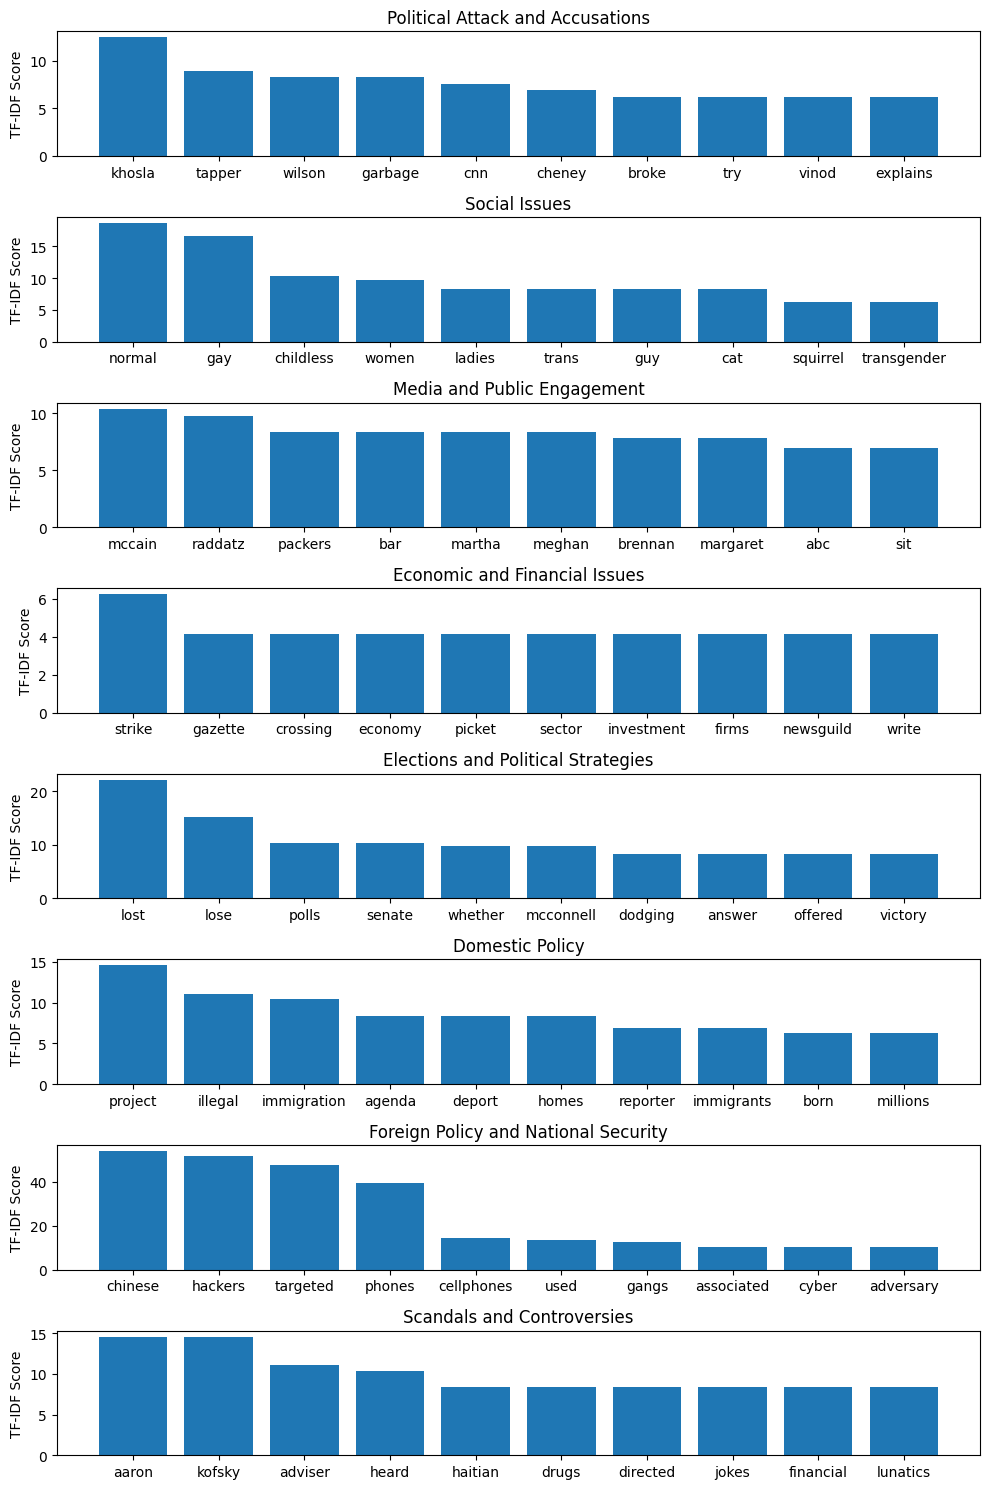

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, ax = plt.subplots(8, figsize=(10,15))
# colors = cm.Blues(np.linspace(0.4, 0.9, 10)[::-1])

for i, (category, data) in enumerate(tf_idf_dict.items()):
    words = [e[0] for e in data]
    scores = [e[1] for e in data]
    ax[i].bar(words, scores)
    ax[i].set_title(category)
    ax[i].set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()

In [29]:
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')
df = df[df['topic pass 2'].map(lambda x: type(x) == str)]
df['date'] = pd.to_datetime(pd.to_datetime(df['publishedAt']).dt.strftime('%m/%d/%Y'))
df = df.sort_values(by='date')
df['count'] = 1
df['is_negative'] = pd.to_numeric(df['negative/neutral/positive'] == 'negative')
df['is_positive'] = pd.to_numeric(df['negative/neutral/positive'] == 'positive')
df['is_neutral'] = pd.to_numeric(df['negative/neutral/positive'] == 'neutral')

In [30]:
df.groupby('date').sum().reset_index()[['is_negative','is_positive','is_neutral']]


,is_negative,is_positive,is_neutral
0,12,9,17
1,6,1,12
2,14,4,10
3,15,2,27
4,7,3,5
5,1,0,1
6,3,2,1
7,4,2,10
8,2,1,9
9,2,4,10


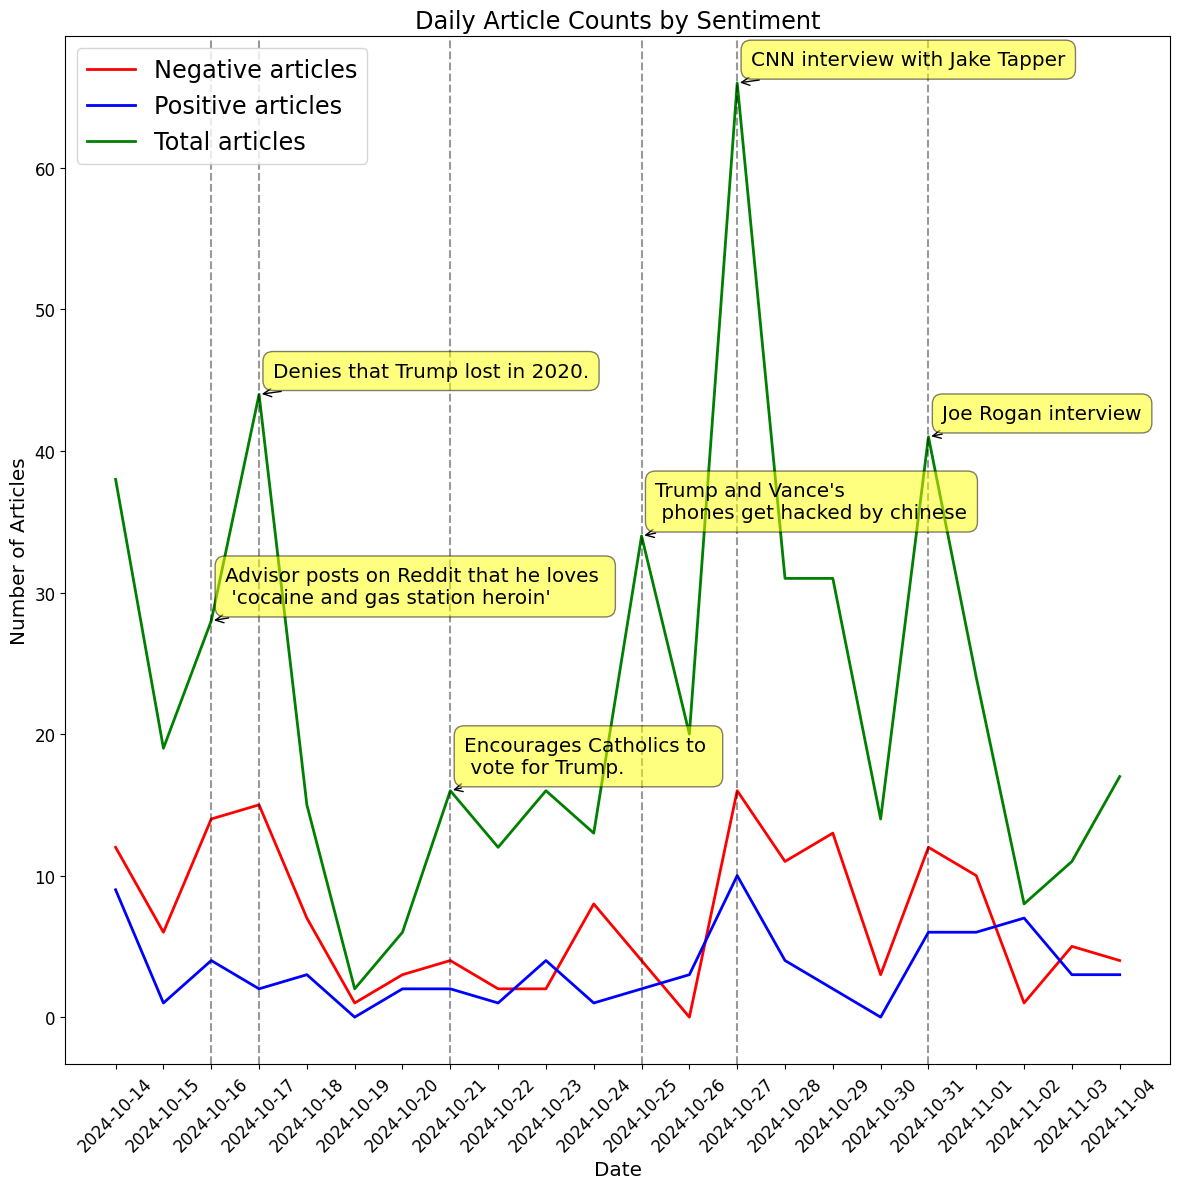

In [64]:
df = pd.read_csv('../data/vance_annotated.tsv', sep='\t')
df = df[df['topic pass 2'].map(lambda x: type(x) == str)]
df['date'] = pd.to_datetime(pd.to_datetime(df['publishedAt']).dt.strftime('%m/%d/%Y'))
df = df.sort_values(by='date')
df['count'] = 1
df['is_negative'] = pd.to_numeric(df['negative/neutral/positive'] == 'negative')
df['is_positive'] = pd.to_numeric(df['negative/neutral/positive'] == 'positive')
df['is_neutral'] = pd.to_numeric(df['negative/neutral/positive'] == 'neutral')

window_size = 1

daily_counts = df.groupby('date').sum().reset_index()

daily_counts['total_avg'] = daily_counts['count'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['neg_avg'] = daily_counts['is_negative'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['pos_avg'] = daily_counts['is_positive'].rolling(window=window_size, center=True, min_periods=1).mean()
daily_counts['neut_avg'] = daily_counts['is_neutral'].rolling(window=window_size, center=True, min_periods=1).mean()

import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt

# Assuming you've already created daily_counts with the 3-day moving average
plt.figure(figsize=(12, 12))
plt.plot(daily_counts['date'], daily_counts['neg_avg'], label=f'Negative articles', color='red', linewidth=2)
plt.plot(daily_counts['date'], daily_counts['pos_avg'], label=f'Positive articles', color='blue', linewidth=2)
plt.plot(daily_counts['date'], daily_counts['total_avg'], label=f'Total articles', color='green', linewidth=2)

# Define your special dates
special_events = {
    '2024-10-16': "Advisor posts on Reddit that he loves \n 'cocaine and gas station heroin'",
    '2024-10-17': 'Denies that Trump lost in 2020.',
    '2024-10-21': 'Encourages Catholics to \n vote for Trump.',
    '2024-10-25': "Trump and Vance's \n phones get hacked by chinese",
    '2024-10-27': "CNN interview with Jake Tapper",
    '2024-10-31': "Joe Rogan interview"
}

# Add vertical lines and annotations for special dates
for date, event in special_events.items():
    # Convert date string to datetime
    event_date = datetime.strptime(date, '%Y-%m-%d')
    
    # Add vertical line
    plt.axvline(x=event_date, color='black', linestyle='--', alpha=0.4)
    
    # Find the y-value at this date for annotation
    y_value = daily_counts.loc[daily_counts['date'] == event_date, 'count'].values[0]
    
    # Annotate the event
    plt.annotate(event, 
                    xy=(event_date, y_value),
                    xytext=(10, 10),
                    textcoords='offset points',
                    ha='left',
                    va='bottom',
                    fontsize='x-large',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
plt.title(f'Daily Article Counts by Sentiment', fontdict={'fontsize':'xx-large'})
plt.xlabel('Date', fontdict={'fontsize':'x-large'})
plt.ylabel('Number of Articles', fontdict={'fontsize':'x-large'})
plt.legend(loc='upper left',fontsize='xx-large')
plt.xticks(ticks=df['date'].unique(),rotation=45, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()

In [10]:
len(df)

506

In [36]:
df.date.dtype

datetime64[ns, UTC]

In [107]:
negative_mask = df['negative/neutral/positive'] == 'negative'
positive_mask = df['negative/neutral/positive'] == 'positive'
neutral_mask = df['negative/neutral/positive'] == 'neutral'

negative_dates = df[negative_mask]['date'].sort_values()
negative_counts = np.cumsum(negative_dates.value_counts(sort=False).to_numpy())
negative_dates = negative_dates.unique()

positive_dates = df[positive_mask]['date'].sort_values()
positive_counts = np.cumsum(positive_dates.value_counts(sort=False).to_numpy())
positive_dates = positive_dates.unique()

In [101]:
positive_dates, positive_counts

(array(['10/14/2024', '10/15/2024', '10/16/2024', '10/17/2024',
        '10/18/2024', '10/20/2024', '10/21/2024', '10/22/2024',
        '10/23/2024', '10/24/2024', '10/25/2024', '10/26/2024',
        '10/27/2024', '10/28/2024', '10/29/2024', '10/31/2024',
        '11/01/2024', '11/02/2024', '11/03/2024', '11/04/2024'],
       dtype=object),
 array([ 9, 10, 14, 16, 19, 21, 23, 24, 28, 29, 31, 34, 44, 48, 50, 56, 62,
        69, 72, 75]))

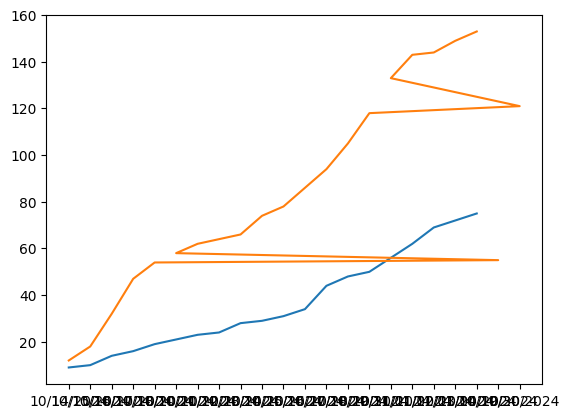

In [108]:
ax = plt.subplot()
ax.plot(positive_dates, positive_counts)
ax.plot(negative_dates, negative_counts)

In [59]:
print(df['negative/neutral/positive'].value_counts().to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
negative/neutral/positive &  \\
\midrule
neutral & 278 \\
negative & 153 \\
positive & 75 \\
\bottomrule
\end{tabular}



In [56]:
counts_df = df.copy()
counts_df['count'] = 1
counts_df = counts_df[['topic pass 2', 'negative/neutral/positive', 'count']]
counts_df.groupby(['topic pass 2', 'negative/neutral/positive']).count()

count
topic pass 2                         negative/neutral/positive       
Domestic Policy                      negative                      20
                                     neutral                       22
                                     positive                       9
Economic and Financial Issues        negative                       7
                                     neutral                        9
                                     positive                       5
Elections and Political Strategies   negative                      27
                                     neutral                       69
                                     positive                      12
Foreign Policy and National Security negative                       1
                                     neutral                       47
                                     positive                       9
Media and Public Engagement          negative                       3
                                     neutral                       44
                                     positive                      19
Political Attack and Accusations     negative                      29
                                     neutral                       37
                                     positive                      12
Scandals and Controversies           negative                      46
                                     neutral                       28
                                     positive                       5
Social Issues                        negative                      20
                                     neutral                       22
                                     positive                       4

In [2]:
import requests
import json
url = "https://political-bias-database.p.rapidapi.com/MBFCdata"

headers = {
	"x-rapidapi-key": "c6ce10f28bmsh47220349b18f48cp1750a0jsn3f5aee38092b",
	"x-rapidapi-host": "political-bias-database.p.rapidapi.com"
}

response = requests.get(url, headers=headers)

d = response.json()

In [3]:
from urllib.parse import urlparse

domain = urlparse('http://www.example.test/foo/bar').netloc


In [4]:
news_df = pd.DataFrame(d)
news_df

,name,profile,url,bias,factual,credibility
0,New Republic – Bias and Credibility,https://mediabiasfactcheck.com/new-republic/,newrepublic.com/,left,high,high credibility
1,Accountable.US – Bias and Credibility,https://mediabiasfactcheck.com/accountable-us/,www.accountable.us/,left,mostly,medium credibility
2,News Corpse – Bias and Credibility,https://mediabiasfactcheck.com/news-corpse/,www.newscorpse.com/,left,mixed,medium credibility
3,NewsHounds – Bias and Credibility,https://mediabiasfactcheck.com/newshounds/,www.newshounds.us/,left,mixed,medium credibility
4,Occupy.com – Bias and Credibility,https://mediabiasfactcheck.com/occupy-com/,www.occupy.com,left,high,high credibility
...,...,...,...,...,...,...
5709,American Military News – Bias and Credibility,https://mediabiasfactcheck.com/american-milita...,americanmilitarynews.com,right-center,mostly,high credibility
5710,The People’s Cube – Bias and Credibility,https://mediabiasfactcheck.com/the-peoples-cube/,thepeoplescube.com/,satire,no factual reporting rating,no credibility rating available
5711,The Shovel – Bias and Credibility,https://mediabiasfactcheck.com/the-shovel/,www.theshovel.com.au/,satire,no factual reporting rating,no credibility rating available
5712,Asian News International (ANI) – Bias and Cred...,https://mediabiasfactcheck.com/asian-news-inte...,www.aninews.in,right-center,mixed,medium credibility


In [5]:
urls = df.url.map(lambda x : urlparse(x).netloc)

In [6]:
aligns = dict()
for url in urls.unique():
    matching_rows = news_df.url.str.contains(url)
    row = news_df[matching_rows]
    if not row.empty:
        bias = row['bias'].values[0]
    else:
        bias = 'N/A'
    aligns[url] = bias

In [7]:
import json
with open('../aligns_dict.json', 'w') as f:
    json.dump(aligns, f)

In [8]:
df['clean_url'] = df['url'].map(lambda x : urlparse(x).netloc)

In [9]:
df['align'] = df['clean_url'].map(lambda x: aligns[x])
valid_df = df[df['align'] != 'N/A']

In [10]:
print(valid_df['align'].value_counts(normalize=True).map(lambda x: str(round(x, 3))).to_latex())

\begin{tabular}{ll}
\toprule
 & proportion \\
align &  \\
\midrule
left & 0.235 \\
right & 0.189 \\
left-center & 0.169 \\
right-center & 0.154 \\
center & 0.131 \\
extreme-right & 0.093 \\
satire & 0.02 \\
conspiracy & 0.005 \\
pro-science & 0.003 \\
\bottomrule
\end{tabular}



In [11]:
valid_df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic pass 2,negative/neutral/positive,clean_url,align
2,NBC News,Henry J. Gomez and Alec Hernández,'Feels kind of weird': Vance reflects and look...,'Feels kind of weird': Vance reflects and look...,https://www.nbcnews.com/politics/2024-election...,2024-11-04T22:15:42Z,"social fabric, friends, political differences",Social Issues,neutral,www.nbcnews.com,left-center
4,New York Post,Emily Crane,JD Vance says Trump is ‘fired up’ over death o...,Republican vice presidential candidate JD Vanc...,https://nypost.com/2024/11/04/us-news/jd-vance...,2024-11-04T15:06:04Z,"media events, Peanut",Social Issues,neutral,nypost.com,right-center
6,NDTV News,Abhinav Singh,'Indulge In Paneer': JD Vance Speaks About Ado...,JD Vance said his wife Usha Vance&#039;s India...,https://www.ndtv.com/world-news/indulge-in-pan...,2024-11-04T02:12:13Z,"personal life, food, culture",Social Issues,neutral,www.ndtv.com,left-center
7,Common Dreams,Lily Eng,"I'm Too Young to Vote, But Not Too Young to Di...",It’s official; the Republican Vice Presidentia...,https://www.commondreams.org/opinion/gun-viole...,2024-11-04T23:00:04Z,school shootings,Social Issues,negative,www.commondreams.org,left
8,Thepinknews.com,Chantelle Billson,JD Vance mocked for saying he ‘wouldn’t be sur...,Republican vice-presidential candidate JD Vanc...,https://www.thepinknews.com/2024/11/04/rogan-j...,2024-11-04T13:53:05Z,"gay vote, elections, podcast",Social Issues,negative,www.thepinknews.com,left


In [12]:
renaming = {'topic pass 2': 'topic'}
df = df.rename(columns=renaming)
clean_df = df[['source', 'author', 'title', 'description', 'url', 'publishedAt', 'topic', 'negative/neutral/positive', 'align']]
clean_df

,source,author,title,description,url,publishedAt,topic,negative/neutral/positive,align
0,Biztoc.com,breakingthenews.net,"JD Vance slams Harris: 'Tomorrow, you're fired'",Republican vice presidential candidate JD Vanc...,https://biztoc.com/x/c4c538f75498736e,2024-11-04T22:53:56Z,Political Attack and Accusations,neutral,N/A
1,Biztoc.com,nbcnews.com,'Feels kind of weird': Vance reflects and look...,"Sen. JD Vance, who says running as Trump's VP ...",https://biztoc.com/x/339813fc9b9bc9be,2024-11-04T22:53:24Z,Social Issues,neutral,N/A
2,NBC News,Henry J. Gomez and Alec Hernández,'Feels kind of weird': Vance reflects and look...,'Feels kind of weird': Vance reflects and look...,https://www.nbcnews.com/politics/2024-election...,2024-11-04T22:15:42Z,Social Issues,neutral,left-center
3,Bleeding Cool News,Ray Flook,Last Week Tonight: HBO Releases John Oliver Se...,"For us, Sunday night's edition of HBO's Last W...",https://bleedingcool.com/tv/last-week-tonight-...,2024-11-04T15:07:08Z,Media and Public Engagement,negative,N/A
4,New York Post,Emily Crane,JD Vance says Trump is ‘fired up’ over death o...,Republican vice presidential candidate JD Vanc...,https://nypost.com/2024/11/04/us-news/jd-vance...,2024-11-04T15:06:04Z,Social Issues,neutral,right-center
...,...,...,...,...,...,...,...,...,...
502,Slashdot.org,feedfeeder,Jake Tapper and JD Vance spar over John Kelly....,Jake Tapper and JD Vance spar over John Kelly....,https://slashdot.org/firehose.pl?op=view&amp;i...,2024-10-27T17:13:15Z,Scandals and Controversies,neutral,N/A
503,Slashdot.org,feedfeeder,"Vance, Tapper spar over ex-Trump administratio...","Vance, Tapper spar over ex-Trump administratio...",https://slashdot.org/firehose.pl?op=view&amp;i...,2024-10-27T17:52:36Z,Political Attack and Accusations,neutral,N/A
504,New York Post,Carson Swick,JD Vance slams Biden-Harris school lunch polic...,Sen. JD Vance (R-Ohio) kept politics mostly ou...,https://nypost.com/2024/10/26/us-news/jd-vance...,2024-10-27T02:35:21Z,Social Issues,neutral,right-center
505,CNN,Kit Maher,Vance insists Trump’s ‘enemy from within’ comm...,Republican vice presidential nominee JD Vance ...,https://www.cnn.com/2024/10/27/politics/jd-van...,2024-10-27T13:00:49Z,Scandals and Controversies,neutral,left


In [13]:
df.head()

,source,author,title,description,url,publishedAt,topic pass 1,topic,negative/neutral/positive,clean_url,align
0,Biztoc.com,breakingthenews.net,"JD Vance slams Harris: 'Tomorrow, you're fired'",Republican vice presidential candidate JD Vanc...,https://biztoc.com/x/c4c538f75498736e,2024-11-04T22:53:56Z,Vance criticises Harris,Political Attack and Accusations,neutral,biztoc.com,N/A
1,Biztoc.com,nbcnews.com,'Feels kind of weird': Vance reflects and look...,"Sen. JD Vance, who says running as Trump's VP ...",https://biztoc.com/x/339813fc9b9bc9be,2024-11-04T22:53:24Z,"social fabric, friends, political differences",Social Issues,neutral,biztoc.com,N/A
2,NBC News,Henry J. Gomez and Alec Hernández,'Feels kind of weird': Vance reflects and look...,'Feels kind of weird': Vance reflects and look...,https://www.nbcnews.com/politics/2024-election...,2024-11-04T22:15:42Z,"social fabric, friends, political differences",Social Issues,neutral,www.nbcnews.com,left-center
3,Bleeding Cool News,Ray Flook,Last Week Tonight: HBO Releases John Oliver Se...,"For us, Sunday night's edition of HBO's Last W...",https://bleedingcool.com/tv/last-week-tonight-...,2024-11-04T15:07:08Z,"news shows, anti-Vance sentiment",Media and Public Engagement,negative,bleedingcool.com,N/A
4,New York Post,Emily Crane,JD Vance says Trump is ‘fired up’ over death o...,Republican vice presidential candidate JD Vanc...,https://nypost.com/2024/11/04/us-news/jd-vance...,2024-11-04T15:06:04Z,"media events, Peanut",Social Issues,neutral,nypost.com,right-center


In [16]:
df['align'].value_counts(normalize=True)

align
N/A              0.218935
left             0.183432
right            0.147929
left-center      0.132150
right-center     0.120316
center           0.102564
extreme-right    0.072978
satire           0.015779
conspiracy       0.003945
pro-science      0.001972
Name: proportion, dtype: float64

In [4]:
pnn_df = df[['topic pass 2', 'negative/neutral/positive']]

In [13]:
import matplotlib.pyplot as plt

def create_sentiment_pie_charts(dataframe):
    """
    Create pie charts of sentiment distribution for each unique topic
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame with 'topic pass 2' and 'negative/neutral/positive' columns
    
    Returns:
    None (displays plots)
    """
    # Get unique topics
    topics = dataframe['topic pass 2'].unique()
    topics = topics[:-1]
    
    # Calculate the number of rows and columns for subplot grid
    n_topics = len(topics)
    n_cols = 2  # Max 3 columns
    n_rows = (n_topics + n_cols - 1) // n_cols  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), squeeze=False)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Create a pie chart for each topic
    for i, topic in enumerate(topics):
        # Filter data for the current topic
        topic_data = dataframe[dataframe['topic pass 2'] == topic]
        
        # Calculate sentiment distribution
        sentiment_counts = topic_data['negative/neutral/positive'].value_counts()
        
        # Plot pie chart
        axes[i].pie(sentiment_counts, labels=sentiment_counts.index, 
                    autopct='%1.1f%%', startangle=90, textprops={'fontsize': 'x-large'})
        axes[i].set_title(topic, fontsize='x-large')
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Example usage
# create_sentiment_pie_charts(pnn_df)

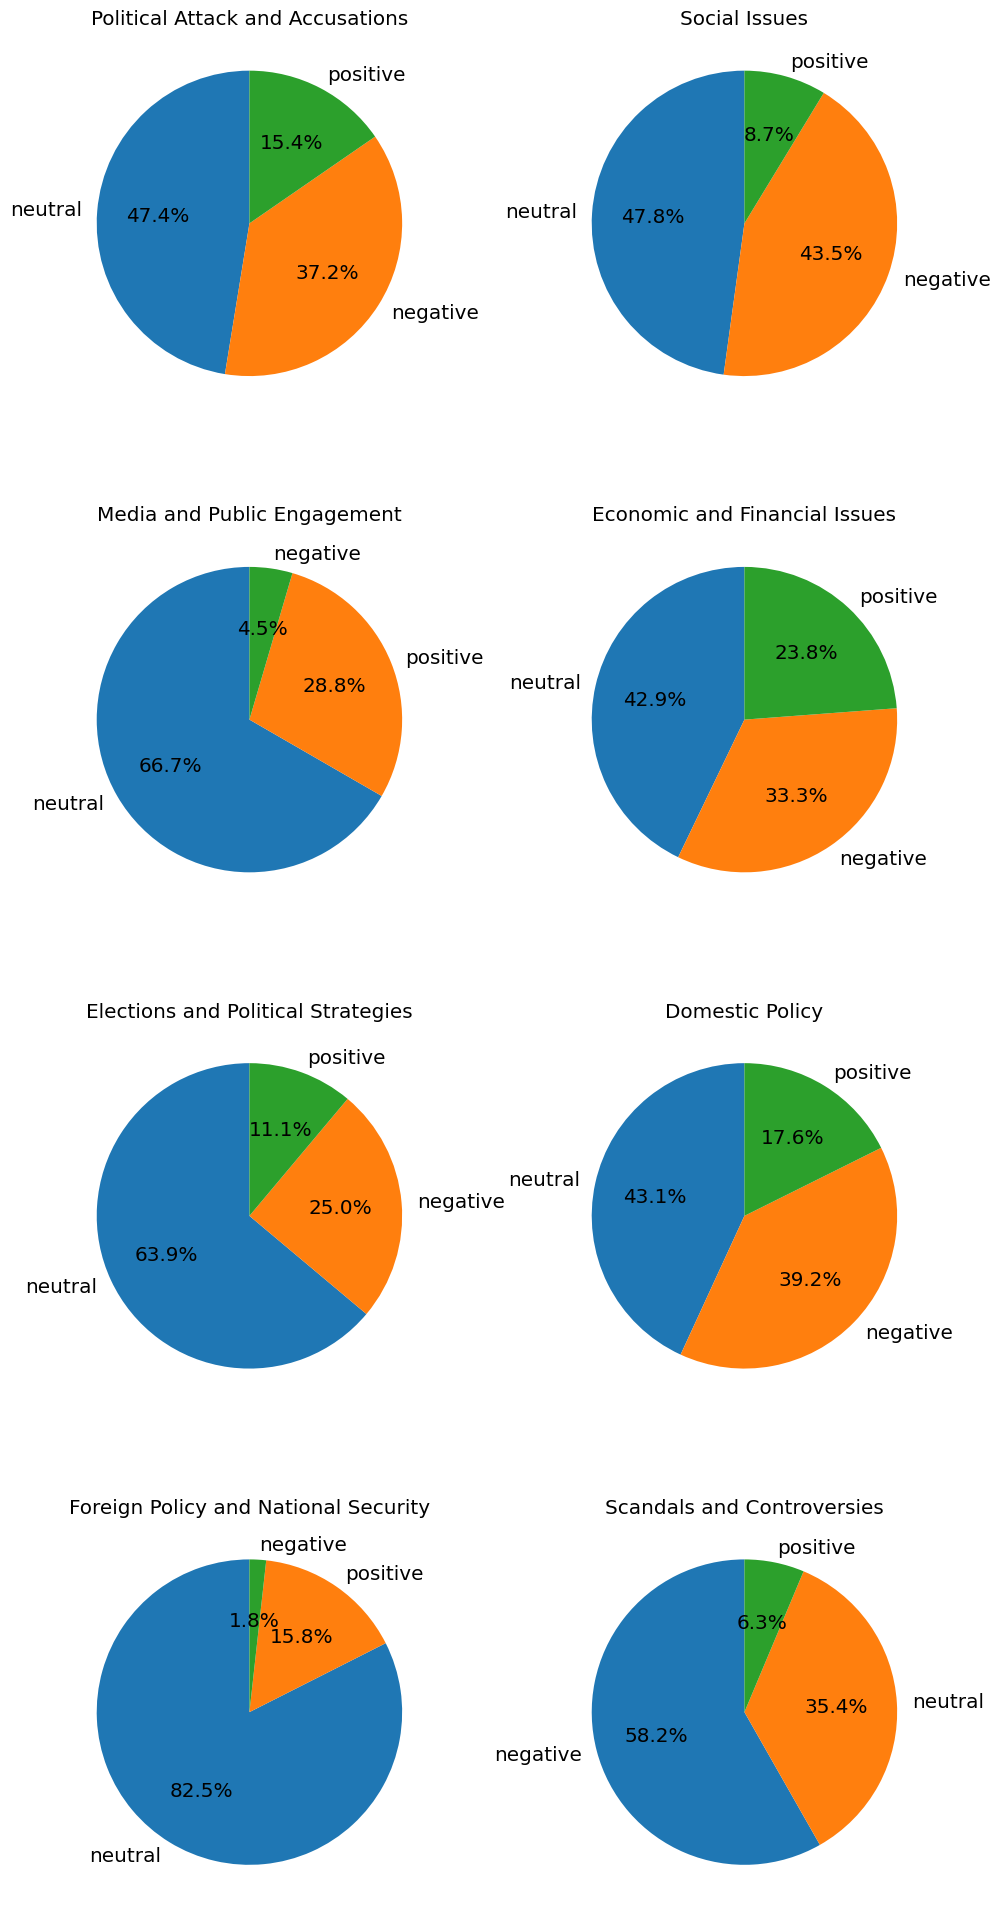

In [14]:
create_sentiment_pie_charts(pnn_df)